สมาชิก
1. นายเมธี พันธุลาภ  62090500419
2. นายวิทูร ร่วมเงิน 62090500420
3. นายอนลัส ไพรอนันต์ 62090500425 
4. นายอานนท์ ภักดิ์ดี  62090500426 
5. นายนิธิโชติ มณีรัตน์ไพโรจน์ 62090500433
6. นายพันธกานต์ ม่วงบัว 62090500436

# ดึงของมูลจาก Yahoo Finance

In [45]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import talib
import seaborn as sns
from sklearn import set_config

import warnings
warnings.filterwarnings('ignore')

set_config(display='diagram')
sns.set()

# GET DATA
N225 = pdr.get_data_yahoo("^N225", start="2012-01-01", end="2019-12-31")
HSI = pdr.get_data_yahoo("^HSI", start="2012-01-01", end="2019-12-31")
DJI = pdr.get_data_yahoo("^DJI", start="2012-01-01", end="2019-12-31")
SSE = pdr.get_data_yahoo("000001.SS", start="2012-01-01", end="2019-12-31")
print(len(N225))
print(len(HSI))
print(len(DJI))
print(len(SSE))

1960
1967
2012
1942


# ประกาศฟังก์ชั่น

In [46]:
def generateUpDown(data):
    
    data['Forecast'] = 0
    data['Real'] = 0
    for i, j, k in zip(data['Close'], data['Close'].iloc[1:], range(0, len(data))):
        if i < j:
            data['Real'].iloc[k] = 1    # DOWN
        elif i > j:
            data['Real'].iloc[k] = 0   # UP
#     for i, j, k in zip(data['EMA50'], data['EMA200'], range(0, len(data))):
#         if i > j:
#             data['Forecast'].iloc[k] = 1    # DOWN
#         elif i < j:
#             data['Forecast'].iloc[k] = 0    # UP

In [47]:
def generateUpDown2(data):
    data['Forecast'] = 0
    for i, j, k in zip(data['y_pred'], data['y_pred'].iloc[1:], range(0, len(data))):
        if i < j:
            data['Forecast'].iloc[k] = 1    # DOWN
        elif i > j:
            data['Forecast'].iloc[k] = 0    # UP

In [48]:
def generateYRegression(data):
    data['Y_Reg'] = 0
    for i, j, k in zip(data['Close'], data['Close'].iloc[1:], range(0, len(data))):
            data['Y_Reg'].iloc[k] = j

In [49]:
def summitAnswer(data):
    data['Answer'] = 0
    up = 0
    down = 0
    for i in range(0, len(data)):
        for j, k in zip(data.iloc[i, :], range(0, len(data.iloc[i, :]))):
            if j == 1:
                if k > 5:
                    up += 3
                else:
                    up += 1
            elif j == 0:
                if k > 5:
                    down += 3
                else:
                    down += 1
        if up > down:
            data['Answer'].iloc[i] = 1
        elif down > up:
            data['Answer'].iloc[i] = 0

# __Nikkei 225 (^N225)__


 ## __<font color=green>Classification</font>__

### PREPARE DATA FOR INDICATOR (เตรียมข้อมูลสำหรับนำไปใส่ Indicator)

In [50]:
open = N225['Open']
high = N225['High']
low = N225['Low']
close = N225['Close']
volume = N225['Volume']

### CREATE INDICATORS (สร้าง Indicator จากข้อมูล open, high, low, close, volume)

#### Overlap Studies

In [51]:
N225['EMA50'] = talib.MA(close, timeperiod=50, matype=0)
N225['EMA200'] = talib.MA(close, timeperiod=200, matype=0)

#### Momentum Indicators

In [52]:
N225['ADX'] = talib.ADX(high, low, close, timeperiod=14)
N225['AROON_DOWN'], N225['AROON_UP'] = talib.AROON(high, low, timeperiod=14)
N225['CCI'] = talib.CCI(high, low, close, timeperiod=14)
N225['MACD'], N225['MACD_SIGNAL'], N225['MACD_HIST'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
N225['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
N225['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
N225['RSI'] = talib.RSI(close, timeperiod=14)
N225['SLOWK'], N225['SLOWD'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
N225['ROC'] = talib.ROC(close, timeperiod=10)

#### Volume Indicators

In [53]:
N225['AD'] = talib.AD(high, low, close, volume)
N225['OBV'] = talib.OBV(close, volume)

#### Volatility Indicator

In [54]:
N225['ATR'] = talib.ATR(high, low, close, timeperiod=14)

#### Pattern Recognition

In [55]:
N225['CDLMORNINGSTAR'] = talib.CDLMORNINGSTAR(open, high, low, close, penetration=0)
N225['CDLENGULFING'] = talib.CDLENGULFING(open, high, low, close)

### Preprocessing data (เตรียมข้อมูลก่อนนำไปใช้ ตย.แก้ข้อมูล NaN, ปรับสัดส่วนข้อมูล/Scaling)

In [57]:
df = N225
df = df.shift(periods=1, axis=0).iloc[1:, :]
# สร้างค่าที่บอกว่าวัน่อไปราคาหุ้นขึ้นหรือลง ขึ้น = 1, ลง = 0)
generateUpDown(df)

# สร้างค่า X(open, high, low, close, volume, indicators) และ y(Up, Down)
# temp = df.dropna()
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

imp = SimpleImputer(strategy='mean', add_indicator=False)
scaler = MinMaxScaler()

num_cols = make_column_selector()

preprocessor = make_column_transformer((make_pipeline(imp, scaler), num_cols))

In [58]:
df

,High,Low,Open,Close,Volume,Adj Close,EMA50,EMA200,ADX,AROON_DOWN,...,SLOWK,SLOWD,ROC,AD,OBV,ATR,CDLMORNINGSTAR,CDLENGULFING,Forecast,Real
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-05,8581.450195,8547.700195,8549.540039,8560.110352,106000000.0,8560.110352,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-2.804583e+07,1.060000e+08,NaN,0.0,0.0,0,0
2012-01-06,8519.160156,8481.830078,8515.660156,8488.709961,77700000.0,8488.709961,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-7.710582e+07,2.830000e+07,NaN,0.0,0.0,0,0
2012-01-10,8488.980469,8349.330078,8488.980469,8390.349609,101300000.0,8390.349609,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.188961e+08,-7.300000e+07,NaN,0.0,0.0,0,1
2012-01-11,8450.589844,8405.179688,8422.990234,8422.259766,112300000.0,8422.259766,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.467175e+08,3.930000e+07,NaN,0.0,0.0,0,1
2012-01-12,8463.719727,8426.030273,8440.959961,8447.879883,106200000.0,8447.879883,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.297834e+08,1.455000e+08,NaN,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,23923.089844,23810.820312,23921.289062,23821.109375,45200000.0,23821.109375,23174.173984,21814.207813,24.914280,7.142857,...,23.398988,44.538035,1.666233,1.114505e+10,2.294200e+10,193.195589,0.0,0.0,0,1
2019-12-25,23853.560547,23796.349609,23839.179688,23830.580078,37900000.0,23830.580078,23219.745977,21825.578164,24.634421,0.000000,...,23.324555,29.700388,1.795759,1.115250e+10,2.297990e+10,183.482400,0.0,0.0,0,0
2019-12-26,23824.849609,23782.869141,23813.589844,23782.869141,31600000.0,23782.869141,23259.425977,21837.566709,24.285338,0.000000,...,22.624387,23.115977,1.671563,1.112090e+10,2.294830e+10,173.784438,0.0,0.0,0,1


### Create Models (สร้าง Models)

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import RidgeClassifier

lr = LogisticRegression(penalty='l1', C=0.1, solver='saga', random_state=1, max_iter=500, tol=0.01, dual=False)
knc = KNeighborsClassifier(n_neighbors=470, p=9, algorithm='auto', leaf_size=30, weights='uniform')
svm = svm.SVC(C=0.3, random_state=1, kernel='linear', gamma='auto', degree=3)
rcf = RidgeClassifier(alpha=20, random_state=1, normalize=True)

### Features Selection (เลือก Features ที่จะใช้เป็น X)

In [60]:
from sklearn.feature_selection import RFE, SelectKBest, chi2
# RFE(modelที่ใช้เลือก, จำนวน Features ที่จะให้เลือก=N)
rfe = RFE(lr, n_features_to_select=10)
chi2_selector = SelectKBest(score_func=chi2, k=10)
chi2_selector

SelectKBest(score_func=<function chi2 at 0x000001D52A77C5E0>)

### Ensemble Models (Model แบบ Ensemble *แบบเอาหลายๆ model มาหาอันที่ดีที่สุดแล้วเอียงไปตอยตามตัวนั้นๆ)

In [61]:
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier([('clf1', lr), ('clf2', knc), ('clf3', svm), ('clf4', rcf)], voting='hard', weights=(2, 1, 1, 1))
vc

VotingClassifier(estimators=[('clf1',
                              LogisticRegression(C=0.1, max_iter=500,
                                                 penalty='l1', random_state=1,
                                                 solver='saga', tol=0.01)),
                             ('clf2',
                              KNeighborsClassifier(n_neighbors=470, p=9)),
                             ('clf3',
                              SVC(C=0.3, gamma='auto', kernel='linear',
                                  random_state=1)),
                             ('clf4',
                              RidgeClassifier(alpha=20, normalize=True,
                                              random_state=1))],
                 weights=(2, 1, 1, 1))

### Splitting data & Training model (แบ่งข้อมูลเป็นส่วนที่ให้ model เรียน กะส่วนที่ให้ model ลองตอบ/ลองเดา)

In [62]:
from sklearn.model_selection import train_test_split

pipe = make_pipeline(preprocessor, rfe, vc)
pipe_lr = make_pipeline(preprocessor, rfe, lr)
pipe_knc = make_pipeline(preprocessor, rfe, knc)
pipe_svm = make_pipeline(preprocessor, rfe, svm)
pipe_rcf = make_pipeline(preprocessor, rfe, rcf)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0, shuffle=False)
 
pipe.fit(X_train, y_train)
pipe_lr.fit(X_train, y_train)
pipe_knc.fit(X_train, y_train)
pipe_svm.fit(X_train, y_train)
pipe_rcf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D52D896A30>)])),
                ('rfe',
                 RFE(estimator=LogisticRegression(C=0.1, max_iter=500,
                                                  penalty='l1', random_state=1,
                                                  solver='saga', tol=0.01),
                     n_features_to_select=10)),
                ('ridgeclassifier',
                 RidgeClassifier(alpha=20, normalize=True, random_state=1))])

### Prediction (ให้ model ลองเดาค่า y_test จาก X_test และ f(X) ที่เคยเรียนไปตอน Training)

In [63]:
y_pred = pipe.predict(X_test)
y_pred_lr = pipe_lr.predict(X_test)
y_pred_knc = pipe_knc.predict(X_test)
y_pred_svm = pipe_svm.predict(X_test)
y_pred_rcf = pipe_rcf.predict(X_test)

In [64]:
N225_answer = pd.DataFrame()
N225_answer['y_pred_lr'] = y_pred_lr
N225_answer['y_pred_knc'] = y_pred_knc
N225_answer['y_pred_svm'] = y_pred_svm
N225_answer['y_pred_rcf'] = y_pred_rcf
N225_answer

,y_pred_lr,y_pred_knc,y_pred_svm,y_pred_rcf
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1
...,...,...,...,...
289,1,1,1,1
290,1,1,1,1
291,1,1,1,1
292,1,1,1,1


### Evaluation (วัดประสิทธิภาพของ model จากค่า Accuracy Score และ Confusion Matrix)

In [65]:
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

# print('Voting')
# print(pipe.score(X_test, y_test))
# print('lr')
# print(pipe_lr.score(X_test, y_test))
# print('knc')
# print(pipe_knc.score(X_test, y_test))
# print('svm')
# print(pipe_svm.score(X_test, y_test))
# print('rcf')
# print(pipe_rcf.score(X_test, y_test))

cm = confusion_matrix(y_test, y_pred)
print('Voting')
print(cm)
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred))

# disp = plot_confusion_matrix(pipe, X_test, y_test)
# plt.show()

cm_lr = confusion_matrix(y_test, y_pred_lr)
print('lr')
print(cm_lr)
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred_lr))

cm_knc = confusion_matrix(y_test, y_pred_knc)
print('knc')
print(cm_knc)
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred_knc))

cm_svm = confusion_matrix(y_test, y_pred_svm)
print('svm')
print(cm_svm)
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred_svm))

cm_rcf = confusion_matrix(y_test, y_pred)
print('rcf')
print(cm_rcf)
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred_rcf))

# pipe.named_steps.rfe.ranking_

# CV mean score
print(cross_val_score(pipe_rcf, X, y, cv=5 ,scoring='accuracy').mean())


Voting
[[  0 134]
 [  0 160]]
Accuracy Score: 0.54421768707483
lr
[[  0 134]
 [  0 160]]
Accuracy Score: 0.54421768707483
knc
[[  6 128]
 [  8 152]]
Accuracy Score: 0.5374149659863946
svm
[[  0 134]
 [  0 160]]
Accuracy Score: 0.54421768707483
rcf
[[  0 134]
 [  0 160]]
Accuracy Score: 0.54421768707483
0.5380291246933556


 ## __<font color=green> Parameter Tuning </font>__ 

In [66]:

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

params = {}
# params = {'voting': ['hard', 'soft'],
#          'weights': [(1, 1, 1, 1), (2, 1 ,1 ,1), (1, 2, 1, 1)]}
# params['columntransformer__pipeline__simpleimputer__add_indicator'] = [False, True]
# params['columntransformer__pipeline__simpleimputer__strategy'] = ['mean', 'median', 'most_frequent', 'constant']
# params['logisticregression__C'] = [0.1, 1, 10]
# params['logisticregression__penalty'] = ['l1', 'l2']
# params['logisticregression__solver'] = ['sag', 'saga']
# params['kneighborsclassifier__n_neighbors'] = [510, 500, 560]
# params['kneighborsclassifier__leaf_size'] = [30, 20, 50, 10]
# params['kneighborsclassifier__p'] = [9, 10, 11 ]
# params['kneighborsclassifier__weights'] = ['distance', 'uniform']
# params['kneighborsclassifier__algorithm'] = ['auto', 'brute', 'ball_tree' ]
# params['svc__C'] = [0.1, 0.2, 0.3]
# params['svc__degree'] = [3, 6, 9, 12]
# params['svc__kernel'] = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
# params['svc__gamma'] = ['scale', 'auto']
# params['ridgeclassifier__alpha'] = [1, 20, 33, 35, 37, 40]
# params['ridgeclassifier__solver'] = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
# params['ridgeclassifier__fit_intercept'] = [True, False]
# params['ridgeclassifier__normalize'] = [True, False]
# params['ridgeclassifier__copy_X'] = [True, False]
# params['ridgeclassifier__positive'] = [True, False]
# params['votingclassifier__voting'] = ['hard', 'soft']
# params['votingclassifier__weights'] = [(1, 1, 1, 1), (2, 1 ,1 ,1), (1, 2, 1, 1), (2, 2, 1, 1)]

grid = GridSearchCV(pipe_rcf, params, cv=5, scoring='accuracy')
grid.fit(X, y)
print(grid.best_params_)
grid.best_score_

# rand = RandomizedSearchCV(pipe_rfr, params, cv=5, n_iter=10, scoring='r2')
# rand.fit(X, y)
# print(rand.best_params_)
# rand.best_score_

# 0.5417380247231522

{}


0.5380291246933556

 ## __<font color=green> Regression </font>__

### Preprocessing data (เตรียมข้อมูลก่อนนำไปใช้ ตย.แก้ข้อมูล NaN, ปรับสัดส่วนข้อมูล/Scaling)

In [68]:
temp = df.dropna().copy()

generateYRegression(temp)

temp['Y_Reg'].iloc[-1] = np.mean(temp['Y_Reg'].iloc[-15:])

X = temp.iloc[:, 6:-2]
y = temp.loc[:, 'Y_Reg']
X_N = temp.iloc[:, 6:-2]
y_N = temp.loc[:, 'Y_Reg']

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

imp = SimpleImputer(strategy='mean', add_indicator=False)
scaler = MinMaxScaler()

num_cols = make_column_selector(dtype_include='number')

preprocessor = make_column_transformer((make_pipeline(imp, scaler), num_cols))

### Create Models (สร้าง Models)

In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor

rfr = RandomForestRegressor(n_estimators=250, criterion='absolute_error', max_features=7, min_samples_leaf=6, min_samples_split=3, random_state=0)
svr = SVR(degree=3, kernel='linear', gamma='scale', C=12.5, coef0=0)
vr = VotingRegressor([('reg1', rfr), ('reg2', svr)],  weights=(1, 2))

### Features Selection (เลือก Features ที่จะใช้เป็น X)

In [70]:
from sklearn.feature_selection import RFE
# RFE(modelที่ใช้เลือก, จำนวน Features ที่จะให้เลือก=N)
rfe = RFE(svr, n_features_to_select=10)

### Splitting data & Training model (แบ่งข้อมูลเป็นส่วนที่ให้ model เรียน กะส่วนที่ให้ model ลองตอบ/ลองเดา)

In [71]:
from sklearn.model_selection import train_test_split

pipe_rfr = make_pipeline(preprocessor, rfe, rfr)
pipe_svr = make_pipeline(preprocessor, rfe, svr)
pipe_vr = make_pipeline(preprocessor, rfe, vr)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0, shuffle=False)
 
pipe_rfr.fit(X_train, y_train)
pipe_svr.fit(X_train, y_train)
pipe_vr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D52A3EDF70>)])),
                ('rfe',
                 RFE(estimator=SVR(C=12.5, coef0=0, kernel='linear'),
                     n_features_to_select=10)),
                ('votingregressor',
                 VotingRegressor(estimators=[('reg1',
                                              RandomForestRegressor(criterion='absolute_error',
                                                                    max_features=7,
                                                                    min_samples_leaf=6,
                                                                    min_samples_split=3,
                                                                    n_estimators=250,
                                                                    random_state=0)),
                                             ('reg2',
                                              SVR(C=12.5, coef0=0,
                                                  kernel='linear'))],
                                 weights=(1, 2)))])

### Prediction (ให้ model ลองเดาค่า y_test จาก X_test และ f(X) ที่เคยเรียนไปต้อน Training)

In [72]:
y_pred_rfr = pipe_rfr.predict(X_test)
y_pred_svr = pipe_svr.predict(X_test)
y_pred_vr = pipe_vr.predict(X_test)

### Evaluation (วัดประสิทธิภาพของ model จากค่า RMSE, R2 score, Accuracy Score และ Confusion Matrix)

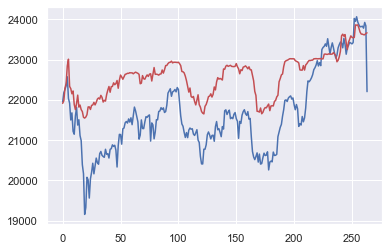

RMSE:      1103.4707543912916
R2 score:  -0.24875801448709556
[[102  16]
 [ 18 128]]
Accuracy Score: 0.8712121212121212


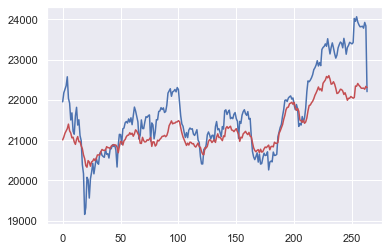

RMSE:      633.5243878300541
R2 score:  0.5883924715782439
[[111   7]
 [ 10 136]]
Accuracy Score: 0.9356060606060606


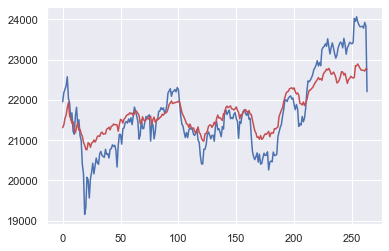

RMSE:      525.7944854611967
R2 score:  0.7164767441224136
[[108  10]
 [  9 137]]
Accuracy Score: 0.928030303030303


In [73]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix

X_test_len = len(X_test)

# y_test_scaled = scaler.fit_transform(y_test)
plt.plot(range(X_test_len), y_test)
plt.plot(range(X_test_len), y_pred_rfr,'r');
plt.show()

rmse = mean_squared_error(y_test, y_pred_rfr, squared=False)
r2 = r2_score(y_test, y_pred_rfr)

print('RMSE:     ', rmse)  # Root mean squared error
print('R2 score: ', r2)

pred_len = len(y_pred_rfr)
test_rfr = pd.DataFrame(data=y_pred_rfr, columns=['y_pred'])
test_rfr['y_pred'] = y_pred_rfr

test_rfr['Real'] = temp.iloc[-pred_len:, -2].values

generateUpDown2(test_rfr)

cm = confusion_matrix(test_rfr['Real'], test_rfr['Forecast'])
print(cm)
print('Accuracy Score:', metrics.accuracy_score(test_rfr['Real'], test_rfr['Forecast']))

# ***SVR***

plt.plot(range(X_test_len), y_test)
plt.plot(range(X_test_len), y_pred_svr,'r');
plt.show()

rmse_svr = mean_squared_error(y_test, y_pred_svr, squared=False)
r2_svr = r2_score(y_test, y_pred_svr)

print('RMSE:     ', rmse_svr)  # Root mean squared error
print('R2 score: ', r2_svr)

pred_len = len(y_pred_svr)
test_svr = pd.DataFrame(data=y_pred_svr, columns=['y_pred'])
test_svr['y_pred'] = y_pred_svr
test_svr['Real'] = temp.iloc[-pred_len:, -2].values

generateUpDown2(test_svr)

cm_svr = confusion_matrix(test_svr['Real'], test_svr['Forecast'])
print(cm_svr)
print('Accuracy Score:', metrics.accuracy_score(test_svr['Real'], test_svr['Forecast']))

# ***Voting regessor***

plt.plot(range(X_test_len), y_test)
plt.plot(range(X_test_len), y_pred_vr,'r');
plt.show()

rmse = mean_squared_error(y_test, y_pred_vr, squared=False)
r2 = r2_score(y_test, y_pred_vr)

print('RMSE:     ', rmse)  # Root mean squared error
print('R2 score: ', r2)

pred_len2 = len(y_pred_vr)
test = pd.DataFrame(data=y_pred_vr, columns=['y_pred'])
test['y_pred'] = y_pred_vr
test['Real'] = temp.iloc[-pred_len2:, -2].values

generateUpDown2(test)

cm = confusion_matrix(test['Real'], test['Forecast'])
print(cm)
print('Accuracy Score:', metrics.accuracy_score(test['Real'], test['Forecast']))

# --------------------------------------------------------------------------------------------------------------------------------------------------

# # ***TRY REAL DATA*** 

# True_predict = pdr.get_data_yahoo("^N225", start="2020-11-01", end="2021-11-25")

# close = True_predict['Close']

# True_predict['EMA50'] = talib.MA(close, timeperiod=50, matype=0)

# True_predict_drop = True_predict.dropna()

# generateUpDown(True_predict_drop)

# X = True_predict_drop.iloc[:, 6].values

# X = scaler.fit_transform(X[:, np.newaxis])


# y_true = svr.predict(X) 

# test_true = pd.DataFrame(data=y_true, columns=['y_true'])
# test_true['y_pred'] = y_true
# test_true['Real'] = True_predict_drop.iloc[:, -1].values

# generateUpDown2(test_true)

# # test_true

# cm = confusion_matrix(test_true['Real'], test_true['Forecast'])
# print(cm)
# print('Accuracy Score:', metrics.accuracy_score(test_true['Real'], test_true['Forecast']))


In [74]:
N225_answer['y_pred_rfr'] = test_rfr.iloc[:, -1]
N225_answer['y_pred_svr'] = test_svr.iloc[:, -1]
N225_answer['y_pred_vr'] = test.iloc[:, -1]
summitAnswer(N225_answer)
N225_answer['Real'] = df.tail(len(N225_answer)).iloc[:, -1].values
cm = confusion_matrix(N225_answer['Real'], N225_answer['Answer'])
print(cm)
print('Accuracy Score:', metrics.accuracy_score(N225_answer['Real'], N225_answer['Answer']))

[[  0 134]
 [  0 160]]
Accuracy Score: 0.54421768707483


 ## __<font color=green> Parameter Tuning </font>__ 

In [75]:

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

params = {}
# params = {'voting': ['hard', 'soft'],
#          'weights': [(1, 1, 1, 1), (2, 1 ,1 ,1), (1, 2, 1, 1)]}
# params['columntransformer__pipeline__simpleimputer__add_indicator'] = [False, True]
# params['columntransformer__pipeline__simpleimputer__strategy'] = ['mean', 'median', 'most_frequent', 'constant']

# params['randomforestregressor__n_estimators'] = [250, 500, 150]
# params['randomforestregressor__criterion'] = ['squared_error', 'absolute_error', 'poisson']

# params['svr__degree'] = [3, 6, 9, 12]
# params['svr__kernel'] = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
# params['svr__gamma'] = ['scale', 'auto']

# params['votingregressor__voting'] = ['hard', 'soft']
# params['votingregressor__weights'] = [(1, 1, 1, 1), (2, 1 ,1 ,1), (1, 2, 1, 1), (2, 2, 1, 1)]

grid = GridSearchCV(pipe_rfr, params, cv=5, scoring='r2')
grid.fit(X, y)
print(grid.best_params_)
grid.best_score_

# rand = RandomizedSearchCV(pipe_rfr, params, cv=5, scoring='r2')
# rand.fit(X, y)
# print(rand.best_params_)
# rand.best_score_

#0.5428743883595157

{}


0.11751568391602504

# __HANG SENG INDEX (^HSI)__

 ## __<font color=green>Classification</font>__

### PREPARE DATA FOR INDICATOR (เตรียมข้อมูลสำหรับนำไปใส่ Indicator)

In [76]:
open = HSI['Open']
high = HSI['High']
low = HSI['Low']
close = HSI['Close']
volume = HSI['Volume']

### CREATE INDICATORS (สร้าง Indicator จากข้อมูล open, high, low, close, volume)

#### Overlap Studies

In [77]:
HSI['EMA50'] = talib.MA(close, timeperiod=50, matype=0)
HSI['EMA200'] = talib.MA(close, timeperiod=200, matype=0)

#### Momentum Indicators

In [78]:
HSI['ADX'] = talib.ADX(high, low, close, timeperiod=14)
HSI['AROON_DOWN'], HSI['AROON_UP'] = talib.AROON(high, low, timeperiod=14)
HSI['CCI'] = talib.CCI(high, low, close, timeperiod=14)
HSI['MACD'], HSI['MACD_SIGNAL'], HSI['MACD_HIST'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
HSI['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
HSI['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
HSI['RSI'] = talib.RSI(close, timeperiod=14)
HSI['SLOWK'], HSI['SLOWD'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
HSI['ROC'] = talib.ROC(close, timeperiod=10)

#### Volume Indicators

In [79]:
HSI['AD'] = talib.AD(high, low, close, volume)
HSI['OBV'] = talib.OBV(close, volume)

#### Volatility Indicator

In [80]:
HSI['ATR'] = talib.ATR(high, low, close, timeperiod=14)

#### Pattern Recognition

In [81]:
HSI['CDLMORNINGSTAR'] = talib.CDLMORNINGSTAR(open, high, low, close, penetration=0)
HSI['CDLENGULFING'] = talib.CDLENGULFING(open, high, low, close)

### Preprocessing data (เตรียมข้อมูลก่อนนำไปใช้ ตย.แก้ข้อมูล NaN, ปรับสัดส่วนข้อมูล/Scaling)

In [82]:
df = HSI

# สร้างค่าที่บอกว่าวัน่อไปราคาหุ้นขึ้นหรือลง ขึ้น = 1, ลง = 0)
generateUpDown(df)

# สร้างค่า X(open, high, low, close, volume, indicators) และ y(Up, Down)
# temp = df.dropna()
X = df.iloc[:, 0:-1]
y = df.loc[:, 'Real']

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

imp = SimpleImputer(strategy='mean', add_indicator=False)
scaler = MinMaxScaler()

num_cols = make_column_selector(dtype_include='number')

preprocessor = make_column_transformer((make_pipeline(imp, scaler), num_cols))

In [83]:
df

,High,Low,Open,Close,Volume,Adj Close,EMA50,EMA200,ADX,AROON_DOWN,...,SLOWK,SLOWD,ROC,AD,OBV,ATR,CDLMORNINGSTAR,CDLENGULFING,Forecast,Real
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,18886.119141,18724.169922,18770.640625,18877.410156,1.247580e+09,18877.410156,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.113400e+09,1.247580e+09,NaN,0,0,0,0
2012-01-04,18970.599609,18687.939453,18970.599609,18727.310547,1.169241e+09,18727.310547,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.698812e+08,7.833910e+07,NaN,0,0,0,1
2012-01-05,18821.089844,18723.279297,18753.380859,18813.410156,1.035427e+09,18813.410156,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.142713e+09,1.113766e+09,NaN,0,0,0,0
2012-01-06,18784.859375,18506.580078,18784.859375,18593.060547,1.434069e+09,18593.060547,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.999714e+08,-3.203029e+08,NaN,0,0,0,1
2012-01-09,18884.259766,18302.839844,18588.359375,18865.720703,1.380952e+09,18865.720703,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.892857e+09,1.060649e+09,NaN,0,100,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,28024.619141,27830.080078,28024.619141,27906.410156,1.216834e+09,27906.410156,26935.587305,27570.626543,20.661977,7.142857,...,78.242392,85.361938,5.328153,1.460822e+11,1.649900e+11,301.554434,0,0,0,0
2019-12-24,27921.289062,27792.660156,27901.509766,27864.210938,4.839841e+08,27864.210938,26962.792930,27564.759600,21.102252,0.000000,...,70.107071,78.268103,5.400054,1.461366e+11,1.645060e+11,289.202610,0,0,0,1
2019-12-27,28226.109375,28000.619141,28033.660156,28225.419922,1.375016e+09,28225.419922,26994.015742,27561.989453,22.174069,0.000000,...,76.110194,74.819886,5.929686,1.475032e+11,1.658810e+11,294.395170,100,0,0,1


### Create Models (สร้าง Models)

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import RidgeClassifier

lr = LogisticRegression(penalty='l1', C=0.1, solver='saga', random_state=1, max_iter=500, tol=0.01, dual=False)
knc = KNeighborsClassifier(n_neighbors=470, p=9, algorithm='auto', leaf_size=30, weights='uniform')
svm = svm.SVC(C=0.3, random_state=1, kernel='linear', gamma='auto', degree=3)
rcf = RidgeClassifier(alpha=20, random_state=1, normalize=True)

### Features Selection (เลือก Features ที่จะใช้เป็น X)

In [85]:
from sklearn.feature_selection import RFE
# RFE(modelที่ใช้เลือก, จำนวน Features ที่จะให้เลือก=N)
rfe = RFE(lr, n_features_to_select=10)
rfe

RFE(estimator=LogisticRegression(C=0.1, max_iter=500, penalty='l1',
                                 random_state=1, solver='saga', tol=0.01),
    n_features_to_select=10)

### Ensemble Models (Model แบบ Ensemble *แบบเอาหลายๆ model มาหาอันที่ดีที่สุดแล้วเอียงไปตอยตามตัวนั้นๆ)

In [86]:
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier([('clf1', lr), ('clf2', knc), ('clf3', svm), ('clf4', rcf)], voting='hard', weights=(2, 1, 1, 1))
vc

VotingClassifier(estimators=[('clf1',
                              LogisticRegression(C=0.1, max_iter=500,
                                                 penalty='l1', random_state=1,
                                                 solver='saga', tol=0.01)),
                             ('clf2',
                              KNeighborsClassifier(n_neighbors=470, p=9)),
                             ('clf3',
                              SVC(C=0.3, gamma='auto', kernel='linear',
                                  random_state=1)),
                             ('clf4',
                              RidgeClassifier(alpha=20, normalize=True,
                                              random_state=1))],
                 weights=(2, 1, 1, 1))

### Splitting data & Training model (แบ่งข้อมูลเป็นส่วนที่ให้ model เรียน กะส่วนที่ให้ model ลองตอบ/ลองเดา)

In [87]:
from sklearn.model_selection import train_test_split

pipe = make_pipeline(preprocessor, rfe, vc)
pipe_lr = make_pipeline(preprocessor, rfe, lr)
pipe_knc = make_pipeline(preprocessor, rfe, knc)
pipe_svm = make_pipeline(preprocessor, rfe, svm)
pipe_rcf = make_pipeline(preprocessor, rfe, rcf)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0, shuffle=False)
 
pipe.fit(X_train, y_train)
pipe_lr.fit(X_train, y_train)
pipe_knc.fit(X_train, y_train)
pipe_svm.fit(X_train, y_train)
pipe_rcf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D508EBB7C0>)])),
                ('rfe',
                 RFE(estimator=LogisticRegression(C=0.1, max_iter=500,
                                                  penalty='l1', random_state=1,
                                                  solver='saga', tol=0.01),
                     n_features_to_select=10)),
                ('ridgeclassifier',
                 RidgeClassifier(alpha=20, normalize=True, random_state=1))])

### Prediction (ให้ model ลองเดาค่า y_test จาก X_test และ f(X) ที่เคยเรียนไปตอน Training)

In [88]:
y_pred = pipe.predict(X_test)
y_pred_lr = pipe_lr.predict(X_test)
y_pred_knc = pipe_knc.predict(X_test)
y_pred_svm = pipe_svm.predict(X_test)
y_pred_rcf = pipe_rcf.predict(X_test)

### Evaluation (วัดประสิทธิภาพของ model จากค่า Accuracy Score และ Confusion Matrix)

In [89]:
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

# print('Voting')
# print(pipe.score(X_test, y_test))
# print('lr')
# print(pipe_lr.score(X_test, y_test))
# print('knc')
# print(pipe_knc.score(X_test, y_test))
# print('svm')
# print(pipe_svm.score(X_test, y_test))
# print('rcf')
# print(pipe_rcf.score(X_test, y_test))

cm = confusion_matrix(y_test, y_pred)
print('Voting')
print(cm)
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred))

# disp = plot_confusion_matrix(pipe, X_test, y_test)
# plt.show()

cm_lr = confusion_matrix(y_test, y_pred_lr)
print('lr')
print(cm_lr)
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred_lr))

cm_knc = confusion_matrix(y_test, y_pred_knc)
print('knc')
print(cm_knc)
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred_knc))

cm_svm = confusion_matrix(y_test, y_pred_svm)
print('svm')
print(cm_svm)
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred_svm))

cm_rcf = confusion_matrix(y_test, y_pred)
print('rcf')
print(cm_rcf)
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred_rcf))

# pipe.named_steps.rfe.ranking_

# CV mean score
# print(cross_val_score(vc, X, y, cv=7 ,scoring='accuracy').mean())


Voting
[[  0 135]
 [  0 161]]
Accuracy Score: 0.543918918918919
lr
[[  0 135]
 [  0 161]]
Accuracy Score: 0.543918918918919
knc
[[  0 135]
 [  0 161]]
Accuracy Score: 0.543918918918919
svm
[[  0 135]
 [  0 161]]
Accuracy Score: 0.543918918918919
rcf
[[  0 135]
 [  0 161]]
Accuracy Score: 0.543918918918919


 ## __<font color=green> Parameter Tuning </font>__

In [90]:

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

params = {}
# params = {'voting': ['hard', 'soft'],
#          'weights': [(1, 1, 1, 1), (2, 1 ,1 ,1), (1, 2, 1, 1)]}
# params['columntransformer__pipeline__simpleimputer__add_indicator'] = [False, True]
# params['columntransformer__pipeline__simpleimputer__strategy'] = ['mean', 'median', 'most_frequent', 'constant']
# params['logisticregression__C'] = [0.1, 1, 10]
# params['logisticregression__penalty'] = ['l1', 'l2']
# params['logisticregression__solver'] = ['sag', 'saga']
# params['kneighborsclassifier__n_neighbors'] = [510, 500, 560]
# params['kneighborsclassifier__leaf_size'] = [30, 20, 50, 10]
# params['kneighborsclassifier__p'] = [9, 10, 11 ]
# params['kneighborsclassifier__weights'] = ['distance', 'uniform']
# params['kneighborsclassifier__algorithm'] = ['auto', 'brute', 'ball_tree' ]
# params['svc__C'] = [0.1, 0.2, 0.3]
# params['svc__degree'] = [3, 6, 9, 12]
# params['svc__kernel'] = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
# params['svc__gamma'] = ['scale', 'auto']
# params['ridgeclassifier__alpha'] = [1, 20, 33, 35, 37, 40]
# params['ridgeclassifier__solver'] = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
# params['ridgeclassifier__fit_intercept'] = [True, False]
# params['ridgeclassifier__normalize'] = [True, False]
# params['votingclassifier__voting'] = ['hard', 'soft']
# params['votingclassifier__weights'] = [(1, 1, 1, 1), (2, 1 ,1 ,1), (1, 2, 1, 1), (2, 2, 1, 1)]

grid = GridSearchCV(pipe_rcf, params, cv=5, scoring='accuracy')
grid.fit(X, y)
print(grid.best_params_)
grid.best_score_

# rand = RandomizedSearchCV(pipe_rfr, params, cv=5, n_iter=10, scoring='r2')
# rand.fit(X, y)
# print(rand.best_params_)
# rand.best_score_

#0.5428743883595157

{}


0.522623060926622

 ## __<font color=green> Regression </font>__

### Preprocessing data (เตรียมข้อมูลก่อนนำไปใช้ ตย.แก้ข้อมูล NaN, ปรับสัดส่วนข้อมูล/Scaling)

In [91]:
temp = df.dropna().copy()

generateYRegression(temp)

temp['Y_Reg'].iloc[-1] = np.mean(temp['Y_Reg'].iloc[-15:])

X = temp.iloc[:, 6:-2]
y = temp.loc[:, 'Y_Reg']

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

imp = SimpleImputer(strategy='mean', add_indicator=False)
scaler = MinMaxScaler()

num_cols = make_column_selector(dtype_include='number')

preprocessor = make_column_transformer((make_pipeline(imp, scaler), num_cols))

### Create Models (สร้าง Models)

In [92]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor

rfr = RandomForestRegressor(n_estimators=250, criterion='absolute_error', max_features=7, min_samples_leaf=6, min_samples_split=3, random_state=0)
svr = SVR(degree=3, kernel='linear', gamma='scale', C=12.5, coef0=0)
vr = VotingRegressor([('reg1', rfr), ('reg2', svr)],  weights=(1, 2))

### Features Selection (เลือก Features ที่จะใช้เป็น X)

In [93]:
from sklearn.feature_selection import RFE
# RFE(modelที่ใช้เลือก, จำนวน Features ที่จะให้เลือก=N)
rfe = RFE(svr, n_features_to_select=10)

### Splitting data & Training model (แบ่งข้อมูลเป็นส่วนที่ให้ model เรียน กะส่วนที่ให้ model ลองตอบ/ลองเดา)

In [94]:
from sklearn.model_selection import train_test_split

pipe_rfr = make_pipeline(preprocessor, rfe, rfr)
pipe_svr = make_pipeline(preprocessor, rfe, svr)
pipe_vr = make_pipeline(preprocessor, rfe, vr)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0, shuffle=False)
 
pipe_rfr.fit(X_train, y_train)
pipe_svr.fit(X_train, y_train)
pipe_vr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D52ECE8F10>)])),
                ('rfe',
                 RFE(estimator=SVR(C=12.5, coef0=0, kernel='linear'),
                     n_features_to_select=10)),
                ('votingregressor',
                 VotingRegressor(estimators=[('reg1',
                                              RandomForestRegressor(criterion='absolute_error',
                                                                    max_features=7,
                                                                    min_samples_leaf=6,
                                                                    min_samples_split=3,
                                                                    n_estimators=250,
                                                                    random_state=0)),
                                             ('reg2',
                                              SVR(C=12.5, coef0=0,
                                                  kernel='linear'))],
                                 weights=(1, 2)))])

### Prediction (ให้ model ลองเดาค่า y_test จาก X_test และ f(X) ที่เคยเรียนไปต้อน Training)

In [98]:
y_pred_rfr = pipe_rfr.predict(X_N)
y_pred_svr = pipe_svr.predict(X_N)
y_pred_vr = pipe_vr.predict(X_N)

### Evaluation (วัดประสิทธิภาพของ model จากค่า RMSE, R2 score, Accuracy Score และ Confusion Matrix)

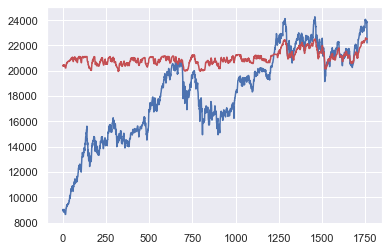

RMSE:      4221.622170074066
R2 score:  -0.45049473491580727
[[364 477]
 [403 516]]
Accuracy Score: 0.5


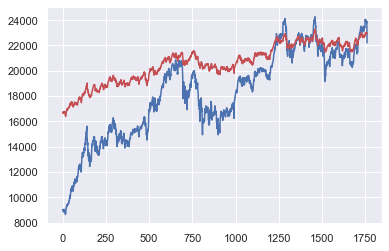

RMSE:      3094.0597850908407
R2 score:  0.22086119457338804
[[326 515]
 [365 554]]
Accuracy Score: 0.5


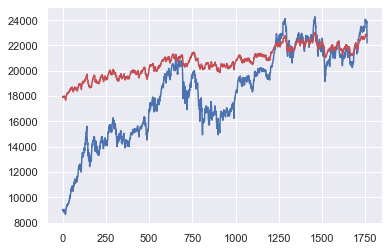

RMSE:      3452.6319909219587
R2 score:  0.029807275734437644
[[338 503]
 [368 551]]
Accuracy Score: 0.5051136363636364


In [100]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix

X_test_len = len(X_N)

# y_test_scaled = scaler.fit_transform(y_test)
plt.plot(range(X_test_len), y_N)
plt.plot(range(X_test_len), y_pred_rfr,'r');
plt.show()

rmse = mean_squared_error(y_N, y_pred_rfr, squared=False)
r2 = r2_score(y_N, y_pred_rfr)

print('RMSE:     ', rmse)  # Root mean squared error
print('R2 score: ', r2)

pred_len = len(y_pred_rfr)
test = pd.DataFrame(data=y_pred_rfr, columns=['y_pred'])
test['y_pred'] = y_pred_rfr

test['Real'] = temp.iloc[-pred_len:, -2].values

generateUpDown2(test)

cm = confusion_matrix(test['Real'], test['Forecast'])
print(cm)
print('Accuracy Score:', metrics.accuracy_score(test['Real'], test['Forecast']))

# ***SVR***

plt.plot(range(X_test_len), y_N)
plt.plot(range(X_test_len), y_pred_svr,'r');
plt.show()

rmse_svr = mean_squared_error(y_N, y_pred_svr, squared=False)
r2_svr = r2_score(y_N, y_pred_svr)

print('RMSE:     ', rmse_svr)  # Root mean squared error
print('R2 score: ', r2_svr)

pred_len = len(y_pred_svr)
test_svr = pd.DataFrame(data=y_pred_svr, columns=['y_pred'])
test_svr['y_pred'] = y_pred_svr
test_svr['Real'] = temp.iloc[-pred_len:, -2].values

generateUpDown2(test_svr)

cm_svr = confusion_matrix(test_svr['Real'], test_svr['Forecast'])
print(cm_svr)
print('Accuracy Score:', metrics.accuracy_score(test_svr['Real'], test_svr['Forecast']))

# ***Voting regessor***

plt.plot(range(X_test_len), y_N)
plt.plot(range(X_test_len), y_pred_vr,'r');
plt.show()

rmse = mean_squared_error(y_N, y_pred_vr, squared=False)
r2 = r2_score(y_N, y_pred_vr)

print('RMSE:     ', rmse)  # Root mean squared error
print('R2 score: ', r2)

pred_len2 = len(y_pred_vr)
test = pd.DataFrame(data=y_pred_vr, columns=['y_pred'])
test['y_pred'] = y_pred_vr
test['Real'] = temp.iloc[-pred_len2:, -2].values

generateUpDown2(test)

cm = confusion_matrix(test['Real'], test['Forecast'])
print(cm)
print('Accuracy Score:', metrics.accuracy_score(test['Real'], test['Forecast']))

# --------------------------------------------------------------------------------------------------------------------------------------------------

# # ***TRY REAL DATA*** 

# True_predict = pdr.get_data_yahoo("^N225", start="2020-11-01", end="2021-11-25")

# close = True_predict['Close']

# True_predict['EMA50'] = talib.MA(close, timeperiod=50, matype=0)

# True_predict_drop = True_predict.dropna()

# generateUpDown(True_predict_drop)

# X = True_predict_drop.iloc[:, 6].values

# X = scaler.fit_transform(X[:, np.newaxis])


# y_true = svr.predict(X) 

# test_true = pd.DataFrame(data=y_true, columns=['y_true'])
# test_true['y_pred'] = y_true
# test_true['Real'] = True_predict_drop.iloc[:, -1].values

# generateUpDown2(test_true)

# # test_true

# cm = confusion_matrix(test_true['Real'], test_true['Forecast'])
# print(cm)
# print('Accuracy Score:', metrics.accuracy_score(test_true['Real'], test_true['Forecast']))


In [97]:
N225_answer = pd.DataFrame()
N225_answer['y_pred_lr'] = y_pred_lr
N225_answer['y_pred_knc'] = y_pred_knc
N225_answer['y_pred_svm'] = y_pred_svm
N225_answer['y_pred_rcf'] = y_pred_rcf
N225_answer['y_pred_rfr'] = test_rfr.iloc[:, -1]
N225_answer['y_pred_svr'] = test_svr.iloc[:, -1]
N225_answer['y_pred_vr'] = test.iloc[:, -1]
summitAnswer(N225_answer)
N225_answer['Real'] = df.tail(len(N225_answer)).iloc[:, -1].values
cm = confusion_matrix(N225_answer['Real'], N225_answer['Answer'])
print(cm)
print('Accuracy Score:', metrics.accuracy_score(N225_answer['Real'], N225_answer['Answer']))

[[  0 135]
 [  0 161]]
Accuracy Score: 0.543918918918919


 ## __<font color=green> Parameter Tuning </font>__ 

In [ ]:

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

params = {}
# params = {'voting': ['hard', 'soft'],
#          'weights': [(1, 1, 1, 1), (2, 1 ,1 ,1), (1, 2, 1, 1)]}
# params['columntransformer__pipeline__simpleimputer__add_indicator'] = [False, True]
# params['columntransformer__pipeline__simpleimputer__strategy'] = ['mean', 'median', 'most_frequent', 'constant']

# params['randomforestregressor__n_estimators'] = [250, 500, 150]
# params['randomforestregressor__criterion'] = ['squared_error', 'absolute_error', 'poisson']

# params['svr__degree'] = [3, 6, 9, 12]
# params['svr__kernel'] = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
# params['svr__gamma'] = ['scale', 'auto']

# params['votingregressor__voting'] = ['hard', 'soft']
# params['votingregressor__weights'] = [(1, 1, 1, 1), (2, 1 ,1 ,1), (1, 2, 1, 1), (2, 2, 1, 1)]

grid = GridSearchCV(pipe_rfr, params, cv=5, scoring='r2')
grid.fit(X, y)
print(grid.best_params_)
grid.best_score_

# rand = RandomizedSearchCV(pipe_rfr, params, cv=5, scoring='r2')
# rand.fit(X, y)
# print(rand.best_params_)
# rand.best_score_

#0.5428743883595157

# __Dow Jones Industrial Average (^DJI)__

 ## __<font color=green>Classification</font>__

### PREPARE DATA FOR INDICATOR (เตรียมข้อมูลสำหรับนำไปใส่ Indicator)

In [29]:
open = DJI['Open']
high = DJI['High']
low = DJI['Low']
close = DJI['Close']
volume = DJI['Volume']

### CREATE INDICATORS (สร้าง Indicator จากข้อมูล open, high, low, close, volume)

#### Overlap Studies

In [30]:
DJI['EMA50'] = talib.MA(close, timeperiod=50, matype=0)
DJI['EMA200'] = talib.MA(close, timeperiod=200, matype=0)

#### Momentum Indicators

In [31]:
DJI['ADX'] = talib.ADX(high, low, close, timeperiod=14)
DJI['AROON_DOWN'], DJI['AROON_UP'] = talib.AROON(high, low, timeperiod=14)
DJI['CCI'] = talib.CCI(high, low, close, timeperiod=14)
DJI['MACD'], DJI['MACD_SIGNAL'], DJI['MACD_HIST'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
DJI['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
DJI['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
DJI['RSI'] = talib.RSI(close, timeperiod=14)
DJI['SLOWK'], DJI['SLOWD'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
DJI['ROC'] = talib.ROC(close, timeperiod=10)

#### Volume Indicators

In [32]:
DJI['AD'] = talib.AD(high, low, close, volume)
DJI['OBV'] = talib.OBV(close, volume)

#### Volatility Indicator

In [33]:
DJI['ATR'] = talib.ATR(high, low, close, timeperiod=14)

#### Pattern Recognition

In [34]:
DJI['CDLMORNINGSTAR'] = talib.CDLMORNINGSTAR(open, high, low, close, penetration=0)
DJI['CDLENGULFING'] = talib.CDLENGULFING(open, high, low, close)

### Preprocessing data (เตรียมข้อมูลก่อนนำไปใช้ ตย.แก้ข้อมูล NaN, ปรับสัดส่วนข้อมูล/Scaling)

In [35]:
df = DJI

# สร้างค่าที่บอกว่าวัน่อไปราคาหุ้นขึ้นหรือลง ขึ้น = 1, ลง = 0)
generateUpDown(df)

# สร้างค่า X(open, high, low, close, volume, indicators) และ y(Up, Down)
# temp = df.dropna()
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

imp = SimpleImputer(strategy='mean', add_indicator=False)
scaler = MinMaxScaler()

num_cols = make_column_selector(dtype_include='number')

preprocessor = make_column_transformer((make_pipeline(imp, scaler), num_cols))

In [36]:
df

,High,Low,Open,Close,Volume,Adj Close,EMA50,EMA200,ADX,AROON_DOWN,...,SLOWK,SLOWD,ROC,AD,OBV,ATR,CDLMORNINGSTAR,CDLENGULFING,Forecast,Real
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,12479.650391,12221.190430,12221.190430,12397.379883,152560000,12397.379883,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.543711e+07,1.525600e+08,NaN,0,0,0,1
2012-01-04,12430.000000,12337.250000,12392.459961,12418.419922,145130000,12418.419922,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.643274e+08,2.976900e+08,NaN,0,0,0,0
2012-01-05,12435.980469,12283.900391,12418.419922,12415.700195,158440000,12415.700195,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.805106e+08,1.392500e+08,NaN,0,0,0,0
2012-01-06,12415.240234,12332.410156,12407.450195,12359.919922,131120000,12359.919922,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.364865e+08,8.130000e+06,NaN,0,0,0,1
2012-01-09,12409.080078,12333.849609,12359.309570,12392.690430,122200000,12392.690430,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.054418e+08,1.303300e+08,NaN,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,28576.800781,28503.210938,28572.570312,28515.449219,86150000,28515.449219,27672.241094,26670.520127,21.107674,7.142857,...,74.409296,79.082098,2.272918,3.774042e+10,3.099933e+10,182.287328,0,0,0,1
2019-12-26,28624.099609,28535.150391,28539.460938,28621.390625,155970000,28621.390625,27704.172891,26685.112627,22.311733,0.000000,...,86.423314,81.075155,2.544094,3.788689e+10,3.115530e+10,177.027547,0,0,0,1
2019-12-27,28701.660156,28608.980469,28675.339844,28645.259766,182280000,28645.259766,27737.038477,26699.789229,23.702622,21.428571,...,83.986709,81.606440,1.824286,3.784732e+10,3.133758e+10,171.002700,0,0,0,0


### Create Models (สร้าง Models)

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import RidgeClassifier

lr = LogisticRegression(penalty='l1', C=0.1, solver='saga', random_state=1, max_iter=500, tol=0.01, dual=False)
knc = KNeighborsClassifier(n_neighbors=470, p=9, algorithm='auto', leaf_size=30, weights='uniform')
svm = svm.SVC(C=0.3, random_state=1, kernel='linear', gamma='auto', degree=3)
rcf = RidgeClassifier(alpha=20, random_state=1, normalize=True)

### Features Selection (เลือก Features ที่จะใช้เป็น X)

In [37]:
from sklearn.feature_selection import RFE
# RFE(modelที่ใช้เลือก, จำนวน Features ที่จะให้เลือก=N)
rfe = RFE(lr, n_features_to_select=10)
rfe

NameError: name 'lr' is not defined

### Ensemble Models (Model แบบ Ensemble *แบบเอาหลายๆ model มาหาอันที่ดีที่สุดแล้วเอียงไปตอยตามตัวนั้นๆ)

In [114]:
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier([('clf1', lr), ('clf2', knc), ('clf3', svm), ('clf4', rcf)], voting='hard', weights=(2, 1, 1, 1))
vc

VotingClassifier(estimators=[('clf1',
                              LogisticRegression(C=0.1, max_iter=500,
                                                 penalty='l1', random_state=1,
                                                 solver='saga', tol=0.01)),
                             ('clf2',
                              KNeighborsClassifier(n_neighbors=470, p=9)),
                             ('clf3',
                              SVC(C=0.3, gamma='auto', kernel='linear',
                                  random_state=1)),
                             ('clf4',
                              RidgeClassifier(alpha=20, normalize=True,
                                              random_state=1))],
                 weights=(2, 1, 1, 1))

### Splitting data & Training model (แบ่งข้อมูลเป็นส่วนที่ให้ model เรียน กะส่วนที่ให้ model ลองตอบ/ลองเดา)

In [115]:
from sklearn.model_selection import train_test_split

pipe = make_pipeline(preprocessor, rfe, vc)
pipe_lr = make_pipeline(preprocessor, rfe, lr)
pipe_knc = make_pipeline(preprocessor, rfe, knc)
pipe_svm = make_pipeline(preprocessor, rfe, svm)
pipe_rcf = make_pipeline(preprocessor, rfe, rcf)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0, shuffle=False)
 
pipe.fit(X_train, y_train)
pipe_lr.fit(X_train, y_train)
pipe_knc.fit(X_train, y_train)
pipe_svm.fit(X_train, y_train)
pipe_rcf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FA7B9B2A90>)])),
                ('rfe',
                 RFE(estimator=LogisticRegression(C=0.1, max_iter=500,
                                                  penalty='l1', random_state=1,
                                                  solver='saga', tol=0.01),
                     n_features_to_select=10)),
                ('ridgeclassifier',
                 RidgeClassifier(alpha=20, normalize=True, random_state=1))])

### Prediction (ให้ model ลองเดาค่า y_test จาก X_test และ f(X) ที่เคยเรียนไปตอน Training)

In [116]:
y_pred = pipe.predict(X_test)
y_pred_lr = pipe_lr.predict(X_test)
y_pred_knc = pipe_knc.predict(X_test)
y_pred_svm = pipe_svm.predict(X_test)
y_pred_rcf = pipe_rcf.predict(X_test)

### Evaluation (วัดประสิทธิภาพของ model จากค่า Accuracy Score และ Confusion Matrix)

In [117]:
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

# print('Voting')
# print(pipe.score(X_test, y_test))
# print('lr')
# print(pipe_lr.score(X_test, y_test))
# print('knc')
# print(pipe_knc.score(X_test, y_test))
# print('svm')
# print(pipe_svm.score(X_test, y_test))
# print('rcf')
# print(pipe_rcf.score(X_test, y_test))

cm = confusion_matrix(y_test, y_pred)
print('Voting')
print(cm)
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred))

# disp = plot_confusion_matrix(pipe, X_test, y_test)
# plt.show()

cm_lr = confusion_matrix(y_test, y_pred_lr)
print('lr')
print(cm_lr)
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred_lr))

cm_knc = confusion_matrix(y_test, y_pred_knc)
print('knc')
print(cm_knc)
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred_knc))

cm_svm = confusion_matrix(y_test, y_pred_svm)
print('svm')
print(cm_svm)
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred_svm))

cm_rcf = confusion_matrix(y_test, y_pred)
print('rcf')
print(cm_rcf)
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred_rcf))

# pipe.named_steps.rfe.ranking_

# CV mean score
# print(cross_val_score(vc, X, y, cv=7 ,scoring='accuracy').mean())


Voting
[[  0 134]
 [  0 168]]
Accuracy Score: 0.5562913907284768
lr
[[  0 134]
 [  0 168]]
Accuracy Score: 0.5562913907284768
knc
[[  0 134]
 [  0 168]]
Accuracy Score: 0.5562913907284768
svm
[[  0 134]
 [  0 168]]
Accuracy Score: 0.5562913907284768
rcf
[[  0 134]
 [  0 168]]
Accuracy Score: 0.5562913907284768


 ## __<font color=green> Parameter Tuning </font>__

In [24]:

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

params = {}
# params = {'voting': ['hard', 'soft'],
#          'weights': [(1, 1, 1, 1), (2, 1 ,1 ,1), (1, 2, 1, 1)]}
# params['columntransformer__pipeline__simpleimputer__add_indicator'] = [False, True]
# params['columntransformer__pipeline__simpleimputer__strategy'] = ['mean', 'median', 'most_frequent', 'constant']
# params['logisticregression__C'] = [0.1, 1, 10]
# params['logisticregression__penalty'] = ['l1', 'l2']
# params['logisticregression__solver'] = ['sag', 'saga']
# params['kneighborsclassifier__n_neighbors'] = [510, 500, 560]
# params['kneighborsclassifier__leaf_size'] = [30, 20, 50, 10]
# params['kneighborsclassifier__p'] = [9, 10, 11 ]
# params['kneighborsclassifier__weights'] = ['distance', 'uniform']
# params['kneighborsclassifier__algorithm'] = ['auto', 'brute', 'ball_tree' ]
# params['svc__C'] = [0.1, 0.2, 0.3]
# params['svc__degree'] = [3, 6, 9, 12]
# params['svc__kernel'] = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
# params['svc__gamma'] = ['scale', 'auto']
# params['ridgeclassifier__alpha'] = [1, 20, 33, 35,37,40]
# params['ridgeclassifier__solver'] = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
# params['ridgeclassifier__fit_intercept'] = [True, False]
# params['ridgeclassifier__normalize'] = [True, False]
# params['votingclassifier__voting'] = ['hard', 'soft']
# params['votingclassifier__weights'] = [(1, 1, 1, 1), (2, 1 ,1 ,1), (1, 2, 1, 1), (2, 2, 1, 1)]

grid = GridSearchCV(pipe_rcf, params, cv=5, scoring='accuracy')
grid.fit(X, y)
print(grid.best_params_)
grid.best_score_

# rand = RandomizedSearchCV(pipe, params, cv=5, n_iter=10, scoring='r2')
# rand.fit(X, y)
# print(rand.best_params_)
# rand.best_score_

#0.5428743883595157

{}


0.5551155115511552

 ## __<font color=green> Regression </font>__

### Preprocessing data (เตรียมข้อมูลก่อนนำไปใช้ ตย.แก้ข้อมูล NaN, ปรับสัดส่วนข้อมูล/Scaling)

In [118]:
temp = df.dropna().copy()

generateYRegression(temp)

temp['Y_Reg'].iloc[-1] = np.mean(temp['Y_Reg'].iloc[-15:])

X = temp.iloc[:, 6:-2]
y = temp.loc[:, 'Y_Reg']

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

imp = SimpleImputer(strategy='mean', add_indicator=False)
scaler = MinMaxScaler()

num_cols = make_column_selector(dtype_include='number')

preprocessor = make_column_transformer((make_pipeline(imp, scaler), num_cols))

### Create Models (สร้าง Models)

In [119]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor

rfr = RandomForestRegressor(n_estimators=250, criterion='absolute_error', max_features=7, min_samples_leaf=6, min_samples_split=3, random_state=0)
svr = SVR(degree=3, kernel='linear', gamma='scale', C=12.5, coef0=0)
vr = VotingRegressor([('reg1', rfr), ('reg2', svr)],  weights=(1, 2))

### Features Selection (เลือก Features ที่จะใช้เป็น X)

In [120]:
from sklearn.feature_selection import RFE
# RFE(modelที่ใช้เลือก, จำนวน Features ที่จะให้เลือก=N)
rfe = RFE(svr, n_features_to_select=10)

### Splitting data & Training model (แบ่งข้อมูลเป็นส่วนที่ให้ model เรียน กะส่วนที่ให้ model ลองตอบ/ลองเดา)

In [121]:
from sklearn.model_selection import train_test_split

pipe_rfr = make_pipeline(preprocessor, rfe, rfr)
pipe_svr = make_pipeline(preprocessor, rfe, svr)
pipe_vr = make_pipeline(preprocessor, rfe, vr)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0, shuffle=False)
 
pipe_rfr.fit(X_train, y_train)
pipe_svr.fit(X_train, y_train)
pipe_vr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FA7B81CCD0>)])),
                ('rfe',
                 RFE(estimator=SVR(C=12.5, coef0=0, kernel='linear'),
                     n_features_to_select=10)),
                ('votingregressor',
                 VotingRegressor(estimators=[('reg1',
                                              RandomForestRegressor(criterion='absolute_error',
                                                                    max_features=7,
                                                                    min_samples_leaf=6,
                                                                    min_samples_split=3,
                                                                    n_estimators=250,
                                                                    random_state=0)),
                                             ('reg2',
                                              SVR(C=12.5, coef0=0,
                                                  kernel='linear'))],
                                 weights=(1, 2)))])

### Prediction (ให้ model ลองเดาค่า y_test จาก X_test และ f(X) ที่เคยเรียนไปต้อน Training)

In [122]:
y_pred_rfr = pipe_rfr.predict(X_test)
y_pred_svr = pipe_svr.predict(X_test)
y_pred_vr = pipe_vr.predict(X_test)

### Evaluation (วัดประสิทธิภาพของ model จากค่า RMSE, R2 score, Accuracy Score และ Confusion Matrix)

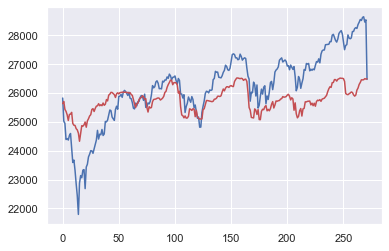

RMSE:      1067.6780513011997
R2 score:  0.2755175665581385
[[ 92  27]
 [ 28 125]]
Accuracy Score: 0.7977941176470589


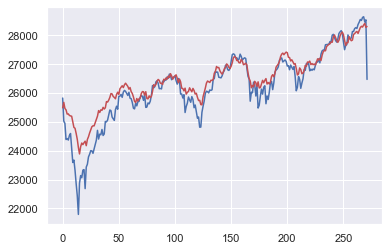

RMSE:      497.3381326344795
R2 score:  0.8428006490324202
[[117   2]
 [ 10 143]]
Accuracy Score: 0.9558823529411765


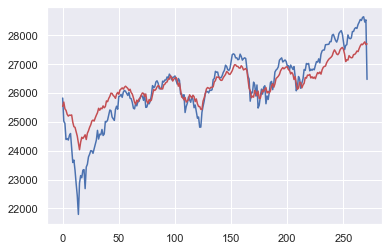

RMSE:      569.6011733772439
R2 score:  0.7937998483073287
[[110   9]
 [ 10 143]]
Accuracy Score: 0.9301470588235294


In [123]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix

X_test_len = len(X_test)

# y_test_scaled = scaler.fit_transform(y_test)
plt.plot(range(X_test_len), y_test)
plt.plot(range(X_test_len), y_pred_rfr,'r');
plt.show()

rmse = mean_squared_error(y_test, y_pred_rfr, squared=False)
r2 = r2_score(y_test, y_pred_rfr)

print('RMSE:     ', rmse)  # Root mean squared error
print('R2 score: ', r2)

pred_len = len(y_pred_rfr)
test_rfr = pd.DataFrame(data=y_pred_rfr, columns=['y_pred'])
test_rfr['y_pred'] = y_pred_rfr

test_rfr['Real'] = temp.iloc[-pred_len:, -2].values

generateUpDown2(test_rfr)

cm = confusion_matrix(test_rfr['Real'], test_rfr['Forecast'])
print(cm)
print('Accuracy Score:', metrics.accuracy_score(test_rfr['Real'], test_rfr['Forecast']))

# ***SVR***

plt.plot(range(X_test_len), y_test)
plt.plot(range(X_test_len), y_pred_svr,'r');
plt.show()

rmse_svr = mean_squared_error(y_test, y_pred_svr, squared=False)
r2_svr = r2_score(y_test, y_pred_svr)

print('RMSE:     ', rmse_svr)  # Root mean squared error
print('R2 score: ', r2_svr)

pred_len = len(y_pred_svr)
test_svr = pd.DataFrame(data=y_pred_svr, columns=['y_pred'])
test_svr['y_pred'] = y_pred_svr
test_svr['Real'] = temp.iloc[-pred_len:, -2].values

generateUpDown2(test_svr)

cm_svr = confusion_matrix(test_svr['Real'], test_svr['Forecast'])
print(cm_svr)
print('Accuracy Score:', metrics.accuracy_score(test_svr['Real'], test_svr['Forecast']))

# ***Voting regessor***

plt.plot(range(X_test_len), y_test)
plt.plot(range(X_test_len), y_pred_vr,'r');
plt.show()

rmse = mean_squared_error(y_test, y_pred_vr, squared=False)
r2 = r2_score(y_test, y_pred_vr)

print('RMSE:     ', rmse)  # Root mean squared error
print('R2 score: ', r2)

pred_len2 = len(y_pred_vr)
test = pd.DataFrame(data=y_pred_vr, columns=['y_pred'])
test['y_pred'] = y_pred_vr
test['Real'] = temp.iloc[-pred_len2:, -2].values

generateUpDown2(test)

cm = confusion_matrix(test['Real'], test['Forecast'])
print(cm)
print('Accuracy Score:', metrics.accuracy_score(test['Real'], test['Forecast']))

# --------------------------------------------------------------------------------------------------------------------------------------------------

# # ***TRY REAL DATA*** 

# True_predict = pdr.get_data_yahoo("^N225", start="2020-11-01", end="2021-11-25")

# close = True_predict['Close']

# True_predict['EMA50'] = talib.MA(close, timeperiod=50, matype=0)

# True_predict_drop = True_predict.dropna()

# generateUpDown(True_predict_drop)

# X = True_predict_drop.iloc[:, 6].values

# X = scaler.fit_transform(X[:, np.newaxis])


# y_true = svr.predict(X) 

# test_true = pd.DataFrame(data=y_true, columns=['y_true'])
# test_true['y_pred'] = y_true
# test_true['Real'] = True_predict_drop.iloc[:, -1].values

# generateUpDown2(test_true)

# # test_true

# cm = confusion_matrix(test_true['Real'], test_true['Forecast'])
# print(cm)
# print('Accuracy Score:', metrics.accuracy_score(test_true['Real'], test_true['Forecast']))


In [124]:
N225_answer = pd.DataFrame()
N225_answer['y_pred_lr'] = y_pred_lr
N225_answer['y_pred_knc'] = y_pred_knc
N225_answer['y_pred_svm'] = y_pred_svm
N225_answer['y_pred_rcf'] = y_pred_rcf
N225_answer['y_pred_rfr'] = test_rfr.iloc[:, -1]
N225_answer['y_pred_svr'] = test_svr.iloc[:, -1]
N225_answer['y_pred_vr'] = test.iloc[:, -1]
summitAnswer(N225_answer)
N225_answer['Real'] = df.tail(len(N225_answer)).iloc[:, -1].values
cm = confusion_matrix(N225_answer['Real'], N225_answer['Answer'])
print(cm)
print('Accuracy Score:', metrics.accuracy_score(N225_answer['Real'], N225_answer['Answer']))

[[ 11 123]
 [ 10 158]]
Accuracy Score: 0.5596026490066225


 ## __<font color=green> Parameter Tuning </font>__ 

In [ ]:

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

params = {}
# params = {'voting': ['hard', 'soft'],
#          'weights': [(1, 1, 1, 1), (2, 1 ,1 ,1), (1, 2, 1, 1)]}
# params['columntransformer__pipeline__simpleimputer__add_indicator'] = [False, True]
# params['columntransformer__pipeline__simpleimputer__strategy'] = ['mean', 'median', 'most_frequent', 'constant']

# params['randomforestregressor__n_estimators'] = [250, 500, 150]
# params['randomforestregressor__criterion'] = ['squared_error', 'absolute_error', 'poisson']

# params['svr__degree'] = [3, 6, 9, 12]
# params['svr__kernel'] = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
# params['svr__gamma'] = ['scale', 'auto']

# params['votingregressor__voting'] = ['hard', 'soft']
# params['votingregressor__weights'] = [(1, 1, 1, 1), (2, 1 ,1 ,1), (1, 2, 1, 1), (2, 2, 1, 1)]

grid = GridSearchCV(pipe_rfr, params, cv=5, scoring='r2')
grid.fit(X, y)
print(grid.best_params_)
grid.best_score_

# rand = RandomizedSearchCV(pipe_rfr, params, cv=5, scoring='r2')
# rand.fit(X, y)
# print(rand.best_params_)
# rand.best_score_

#0.5428743883595157

# __SSE Composite Index (000001.SS)__

 ## __<font color=green>Classification</font>__

### PREPARE DATA FOR INDICATOR (เตรียมข้อมูลสำหรับนำไปใส่ Indicator)

In [125]:
open = SSE['Open']
high = SSE['High']
low = SSE['Low']
close = SSE['Close']
volume = SSE['Volume']

### CREATE INDICATORS (สร้าง Indicator จากข้อมูล open, high, low, close, volume)

#### Overlap Studies

In [126]:
SSE['EMA50'] = talib.MA(close, timeperiod=50, matype=0)
SSE['EMA200'] = talib.MA(close, timeperiod=200, matype=0)

#### Momentum Indicators

In [127]:
SSE['ADX'] = talib.ADX(high, low, close, timeperiod=14)
SSE['AROON_DOWN'], SSE['AROON_UP'] = talib.AROON(high, low, timeperiod=14)
SSE['CCI'] = talib.CCI(high, low, close, timeperiod=14)
SSE['MACD'], SSE['MACD_SIGNAL'], SSE['MACD_HIST'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
SSE['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
SSE['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
SSE['RSI'] = talib.RSI(close, timeperiod=14)
SSE['SLOWK'], SSE['SLOWD'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
SSE['ROC'] = talib.ROC(close, timeperiod=10)

#### Volume Indicators

In [128]:
SSE['AD'] = talib.AD(high, low, close, volume)
SSE['OBV'] = talib.OBV(close, volume)

#### Volatility Indicator

In [129]:
SSE['ATR'] = talib.ATR(high, low, close, timeperiod=14)

#### Pattern Recognition

In [130]:
SSE['CDLMORNINGSTAR'] = talib.CDLMORNINGSTAR(open, high, low, close, penetration=0)
SSE['CDLENGULFING'] = talib.CDLENGULFING(open, high, low, close)

### Preprocessing data (เตรียมข้อมูลก่อนนำไปใช้ ตย.แก้ข้อมูล NaN, ปรับสัดส่วนข้อมูล/Scaling)

In [131]:
df = SSE

# สร้างค่าที่บอกว่าวัน่อไปราคาหุ้นขึ้นหรือลง ขึ้น = 1, ลง = 0)
generateUpDown(df)

# สร้างค่า X(open, high, low, close, volume, indicators) และ y(Up, Down)
temp = df.dropna()
X = temp.iloc[:, 0:-1]
y = temp.iloc[:, -1]

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

imp = SimpleImputer(strategy='mean', add_indicator=False)
scaler = MinMaxScaler()

num_cols = make_column_selector(dtype_include='number')

preprocessor = make_column_transformer((make_pipeline(imp, scaler), num_cols))

In [132]:
df

,High,Low,Open,Close,Volume,Adj Close,EMA50,EMA200,ADX,AROON_DOWN,...,SLOWK,SLOWD,ROC,AD,OBV,ATR,CDLMORNINGSTAR,CDLENGULFING,Forecast,Real
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,2217.520020,2168.644043,2211.995117,2169.389893,49200.0,2169.389893,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-4.769841e+04,49200.0,NaN,0,0,0,0
2012-01-05,2183.404053,2145.555908,2160.896973,2148.451904,58800.0,2148.451904,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-9.750011e+04,-9600.0,NaN,0,0,0,1
2012-01-06,2164.322021,2132.625977,2148.146973,2163.395020,50600.0,2163.395020,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-4.985986e+04,41000.0,NaN,0,100,0,1
2012-01-09,2226.218018,2148.452881,2164.740967,2225.889893,76800.0,2225.889893,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.629203e+04,117800.0,NaN,0,0,0,1
2012-01-10,2288.627930,2218.274902,2221.832031,2285.743896,109600.0,2285.743896,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.269062e+05,227400.0,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,2988.291992,2970.656982,2980.427979,2981.881104,175700.0,2981.881104,2938.233262,2965.760865,23.718514,0.000000,...,21.825721,32.772960,1.964977,6.404680e+07,42487200.0,26.694833,0,0,0,1
2019-12-26,3007.354980,2980.396973,2981.249023,3007.354980,182400.0,3007.354980,2938.833760,2965.659761,23.924256,0.000000,...,44.174142,32.088445,3.143569,6.422920e+07,42669600.0,26.713631,0,0,0,0
2019-12-27,3036.113037,3003.631104,3006.852051,3005.035889,247100.0,3005.035889,2940.171680,2965.413705,24.842004,7.142857,...,53.633155,39.877672,1.258893,6.400348e+07,42422500.0,27.125652,0,0,0,1


### Create Models (สร้าง Models)

In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import RidgeClassifier

lr = LogisticRegression(penalty='l1', C=0.1, solver='saga', random_state=1, max_iter=500, tol=0.01, dual=False)
knc = KNeighborsClassifier(n_neighbors=470, p=9, algorithm='auto', leaf_size=30, weights='uniform')
svm = svm.SVC(C=0.3, random_state=1, kernel='linear', gamma='auto', degree=3)
rcf = RidgeClassifier(alpha=20, random_state=1, normalize=True)

### Features Selection (เลือก Features ที่จะใช้เป็น X)

In [134]:
from sklearn.feature_selection import RFE
# RFE(modelที่ใช้เลือก, จำนวน Features ที่จะให้เลือก=N)
rfe = RFE(lr, n_features_to_select=10)
rfe

RFE(estimator=LogisticRegression(C=0.1, max_iter=500, penalty='l1',
                                 random_state=1, solver='saga', tol=0.01),
    n_features_to_select=10)

### Ensemble Models (Model แบบ Ensemble *แบบเอาหลายๆ model มาหาอันที่ดีที่สุดแล้วเอียงไปตอยตามตัวนั้นๆ)

In [135]:
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier([('clf1', lr), ('clf2', knc), ('clf3', svm), ('clf4', rcf)], voting='hard', weights=(2, 1, 1, 1))
vc

VotingClassifier(estimators=[('clf1',
                              LogisticRegression(C=0.1, max_iter=500,
                                                 penalty='l1', random_state=1,
                                                 solver='saga', tol=0.01)),
                             ('clf2',
                              KNeighborsClassifier(n_neighbors=470, p=9)),
                             ('clf3',
                              SVC(C=0.3, gamma='auto', kernel='linear',
                                  random_state=1)),
                             ('clf4',
                              RidgeClassifier(alpha=20, normalize=True,
                                              random_state=1))],
                 weights=(2, 1, 1, 1))

### Splitting data & Training model (แบ่งข้อมูลเป็นส่วนที่ให้ model เรียน กะส่วนที่ให้ model ลองตอบ/ลองเดา)

In [136]:
from sklearn.model_selection import train_test_split

pipe = make_pipeline(preprocessor, rfe, vc)
pipe_lr = make_pipeline(preprocessor, rfe, lr)
pipe_knc = make_pipeline(preprocessor, rfe, knc)
pipe_svm = make_pipeline(preprocessor, rfe, svm)
pipe_rcf = make_pipeline(preprocessor, rfe, rcf)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0, shuffle=False)
 
pipe.fit(X_train, y_train)
pipe_lr.fit(X_train, y_train)
pipe_knc.fit(X_train, y_train)
pipe_svm.fit(X_train, y_train)
pipe_rcf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FA7BA10130>)])),
                ('rfe',
                 RFE(estimator=LogisticRegression(C=0.1, max_iter=500,
                                                  penalty='l1', random_state=1,
                                                  solver='saga', tol=0.01),
                     n_features_to_select=10)),
                ('ridgeclassifier',
                 RidgeClassifier(alpha=20, normalize=True, random_state=1))])

### Prediction (ให้ model ลองเดาค่า y_test จาก X_test และ f(X) ที่เคยเรียนไปตอน Training)

In [137]:
y_pred = pipe.predict(X_test)
y_pred_lr = pipe_lr.predict(X_test)
y_pred_knc = pipe_knc.predict(X_test)
y_pred_svm = pipe_svm.predict(X_test)
y_pred_rcf = pipe_rcf.predict(X_test)

### Evaluation (วัดประสิทธิภาพของ model จากค่า Accuracy Score และ Confusion Matrix)

In [138]:
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

# print('Voting')
# print(pipe.score(X_test, y_test))
# print('lr')
# print(pipe_lr.score(X_test, y_test))
# print('knc')
# print(pipe_knc.score(X_test, y_test))
# print('svm')
# print(pipe_svm.score(X_test, y_test))
# print('rcf')
# print(pipe_rcf.score(X_test, y_test))

cm = confusion_matrix(y_test, y_pred)
print('Voting')
print(cm)
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred))

# disp = plot_confusion_matrix(pipe, X_test, y_test)
# plt.show()

cm_lr = confusion_matrix(y_test, y_pred_lr)
print('lr')
print(cm_lr)
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred_lr))

cm_knc = confusion_matrix(y_test, y_pred_knc)
print('knc')
print(cm_knc)
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred_knc))

cm_svm = confusion_matrix(y_test, y_pred_svm)
print('svm')
print(cm_svm)
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred_svm))

cm_rcf = confusion_matrix(y_test, y_pred)
print('rcf')
print(cm_rcf)
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred_rcf))

# pipe.named_steps.rfe.ranking_

# CV mean score
# print(cross_val_score(vc, X, y, cv=7 ,scoring='accuracy').mean())


Voting
[[  0 124]
 [  0 138]]
Accuracy Score: 0.5267175572519084
lr
[[  0 124]
 [  0 138]]
Accuracy Score: 0.5267175572519084
knc
[[  0 124]
 [  0 138]]
Accuracy Score: 0.5267175572519084
svm
[[  0 124]
 [  0 138]]
Accuracy Score: 0.5267175572519084
rcf
[[  0 124]
 [  0 138]]
Accuracy Score: 0.5267175572519084


 ## __<font color=green> Parameter Tuning </font>__

In [139]:

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

params = {}
# params = {'voting': ['hard', 'soft'],
#          'weights': [(1, 1, 1, 1), (2, 1 ,1 ,1), (1, 2, 1, 1)]}
# params['columntransformer__pipeline__simpleimputer__add_indicator'] = [False, True]
# params['columntransformer__pipeline__simpleimputer__strategy'] = ['mean', 'median', 'most_frequent', 'constant']
# params['logisticregression__C'] = [0.1, 1, 10]
# params['logisticregression__penalty'] = ['l1', 'l2']
# params['logisticregression__solver'] = ['sag', 'saga']
# params['kneighborsclassifier__n_neighbors'] = [510, 500, 560]
# params['kneighborsclassifier__leaf_size'] = [30, 20, 50, 10]
# params['kneighborsclassifier__p'] = [9, 10, 11 ]
# params['kneighborsclassifier__weights'] = ['distance', 'uniform']
# params['kneighborsclassifier__algorithm'] = ['auto', 'brute', 'ball_tree' ]
# params['svc__C'] = [0.1, 0.2, 0.3]
# params['svc__degree'] = [3, 6, 9, 12]
# params['svc__kernel'] = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
# params['svc__gamma'] = ['scale', 'auto']
# params['ridgeclassifier__alpha'] = [1, 20, 33, 35,37,40]
# params['ridgeclassifier__solver'] = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
# params['ridgeclassifier__fit_intercept'] = [True, False]
# params['ridgeclassifier__normalize'] = [True, False]
# params['votingclassifier__voting'] = ['hard', 'soft']
# params['votingclassifier__weights'] = [(1, 1, 1, 1), (2, 1 ,1 ,1), (1, 2, 1, 1), (2, 2, 1, 1)]

grid = GridSearchCV(pipe_rcf, params, cv=5, scoring='accuracy')
grid.fit(X, y)
print(grid.best_params_)
grid.best_score_

# rand = RandomizedSearchCV(pipe, params, cv=5, n_iter=10, scoring='r2')
# rand.fit(X, y)
# print(rand.best_params_)
# rand.best_score_

# 0.5428743883595157

{}


0.5358577874386589

 ## __<font color=green> Regression </font>__

### Preprocessing data (เตรียมข้อมูลก่อนนำไปใช้ ตย.แก้ข้อมูล NaN, ปรับสัดส่วนข้อมูล/Scaling)

In [140]:
temp = df.dropna().copy()

generateYRegression(temp)

temp['Y_Reg'].iloc[-1] = np.mean(temp['Y_Reg'].iloc[-15:])

X = temp.iloc[:, 6:-2]
y = temp.loc[:, 'Y_Reg']

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

imp = SimpleImputer(strategy='mean', add_indicator=False)
scaler = MinMaxScaler()

num_cols = make_column_selector(dtype_include='number')

preprocessor = make_column_transformer((make_pipeline(imp, scaler), num_cols))

### Create Models (สร้าง Models)

In [141]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor

rfr = RandomForestRegressor(n_estimators=250, criterion='absolute_error', max_features=7, min_samples_leaf=6, min_samples_split=3, random_state=0)
svr = SVR(degree=3, kernel='linear', gamma='scale', C=12.5, coef0=0)
vr = VotingRegressor([('reg1', rfr), ('reg2', svr)],  weights=(1, 2))

### Features Selection (เลือก Features ที่จะใช้เป็น X)

In [142]:
from sklearn.feature_selection import RFE
# RFE(modelที่ใช้เลือก, จำนวน Features ที่จะให้เลือก=N)
rfe = RFE(svr, n_features_to_select=10)

### Splitting data & Training model (แบ่งข้อมูลเป็นส่วนที่ให้ model เรียน กะส่วนที่ให้ model ลองตอบ/ลองเดา)

In [143]:
from sklearn.model_selection import train_test_split

pipe_rfr = make_pipeline(preprocessor, rfe, rfr)
pipe_svr = make_pipeline(preprocessor, rfe, svr)
pipe_vr = make_pipeline(preprocessor, rfe, vr)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0, shuffle=False)
 
pipe_rfr.fit(X_train, y_train)
pipe_svr.fit(X_train, y_train)
pipe_vr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FA7603F910>)])),
                ('rfe',
                 RFE(estimator=SVR(C=12.5, coef0=0, kernel='linear'),
                     n_features_to_select=10)),
                ('votingregressor',
                 VotingRegressor(estimators=[('reg1',
                                              RandomForestRegressor(criterion='absolute_error',
                                                                    max_features=7,
                                                                    min_samples_leaf=6,
                                                                    min_samples_split=3,
                                                                    n_estimators=250,
                                                                    random_state=0)),
                                             ('reg2',
                                              SVR(C=12.5, coef0=0,
                                                  kernel='linear'))],
                                 weights=(1, 2)))])

### Prediction (ให้ model ลองเดาค่า y_test จาก X_test และ f(X) ที่เคยเรียนไปต้อน Training)

In [144]:
y_pred_rfr = pipe_rfr.predict(X_test)
y_pred_svr = pipe_svr.predict(X_test)
y_pred_vr = pipe_vr.predict(X_test)

### Evaluation (วัดประสิทธิภาพของ model จากค่า RMSE, R2 score, Accuracy Score และ Confusion Matrix)

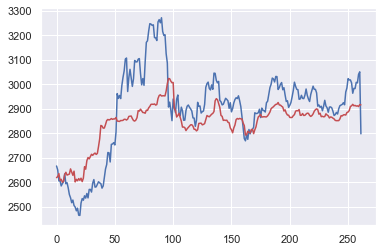

RMSE:      124.65002921031575
R2 score:  0.5021391954634009
[[ 82  42]
 [ 33 105]]
Accuracy Score: 0.7137404580152672


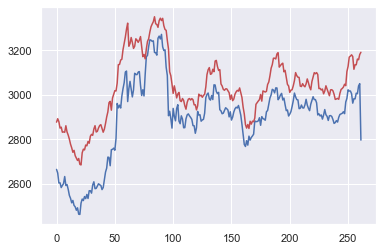

RMSE:      155.37637967983213
R2 score:  0.22644149852451378
[[108  16]
 [ 10 128]]
Accuracy Score: 0.9007633587786259


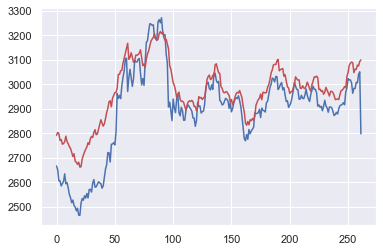

RMSE:      106.35575529676224
R2 score:  0.6375524573576636
[[103  21]
 [  9 129]]
Accuracy Score: 0.8854961832061069


In [145]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix

X_test_len = len(X_test)

# y_test_scaled = scaler.fit_transform(y_test)
plt.plot(range(X_test_len), y_test)
plt.plot(range(X_test_len), y_pred_rfr,'r');
plt.show()

rmse = mean_squared_error(y_test, y_pred_rfr, squared=False)
r2 = r2_score(y_test, y_pred_rfr)

print('RMSE:     ', rmse)  # Root mean squared error
print('R2 score: ', r2)

pred_len = len(y_pred_rfr)
test_rfr = pd.DataFrame(data=y_pred_rfr, columns=['y_pred'])
test_rfr['y_pred'] = y_pred_rfr

test_rfr['Real'] = temp.iloc[-pred_len:, -2].values

generateUpDown2(test_rfr)

cm = confusion_matrix(test_rfr['Real'], test_rfr['Forecast'])
print(cm)
print('Accuracy Score:', metrics.accuracy_score(test_rfr['Real'], test_rfr['Forecast']))

# ***SVR***

plt.plot(range(X_test_len), y_test)
plt.plot(range(X_test_len), y_pred_svr,'r');
plt.show()

rmse_svr = mean_squared_error(y_test, y_pred_svr, squared=False)
r2_svr = r2_score(y_test, y_pred_svr)

print('RMSE:     ', rmse_svr)  # Root mean squared error
print('R2 score: ', r2_svr)

pred_len = len(y_pred_svr)
test_svr = pd.DataFrame(data=y_pred_svr, columns=['y_pred'])
test_svr['y_pred'] = y_pred_svr
test_svr['Real'] = temp.iloc[-pred_len:, -2].values

generateUpDown2(test_svr)

cm_svr = confusion_matrix(test_svr['Real'], test_svr['Forecast'])
print(cm_svr)
print('Accuracy Score:', metrics.accuracy_score(test_svr['Real'], test_svr['Forecast']))

# ***Voting regessor***

plt.plot(range(X_test_len), y_test)
plt.plot(range(X_test_len), y_pred_vr,'r');
plt.show()

rmse = mean_squared_error(y_test, y_pred_vr, squared=False)
r2 = r2_score(y_test, y_pred_vr)

print('RMSE:     ', rmse)  # Root mean squared error
print('R2 score: ', r2)

pred_len2 = len(y_pred_vr)
test = pd.DataFrame(data=y_pred_vr, columns=['y_pred'])
test['y_pred'] = y_pred_vr
test['Real'] = temp.iloc[-pred_len2:, -2].values

generateUpDown2(test)

cm = confusion_matrix(test['Real'], test['Forecast'])
print(cm)
print('Accuracy Score:', metrics.accuracy_score(test['Real'], test['Forecast']))

# --------------------------------------------------------------------------------------------------------------------------------------------------

# # ***TRY REAL DATA*** 

# True_predict = pdr.get_data_yahoo("^N225", start="2020-11-01", end="2021-11-25")

# close = True_predict['Close']

# True_predict['EMA50'] = talib.MA(close, timeperiod=50, matype=0)

# True_predict_drop = True_predict.dropna()

# generateUpDown(True_predict_drop)

# X = True_predict_drop.iloc[:, 6].values

# X = scaler.fit_transform(X[:, np.newaxis])


# y_true = svr.predict(X) 

# test_true = pd.DataFrame(data=y_true, columns=['y_true'])
# test_true['y_pred'] = y_true
# test_true['Real'] = True_predict_drop.iloc[:, -1].values

# generateUpDown2(test_true)

# # test_true

# cm = confusion_matrix(test_true['Real'], test_true['Forecast'])
# print(cm)
# print('Accuracy Score:', metrics.accuracy_score(test_true['Real'], test_true['Forecast']))


In [146]:
N225_answer = pd.DataFrame()
N225_answer['y_pred_lr'] = y_pred_lr
N225_answer['y_pred_knc'] = y_pred_knc
N225_answer['y_pred_svm'] = y_pred_svm
N225_answer['y_pred_rcf'] = y_pred_rcf
N225_answer['y_pred_rfr'] = test_rfr.iloc[:, -1]
N225_answer['y_pred_svr'] = test_svr.iloc[:, -1]
N225_answer['y_pred_vr'] = test.iloc[:, -1]
summitAnswer(N225_answer)
N225_answer['Real'] = df.tail(len(N225_answer)).iloc[:, -1].values
cm = confusion_matrix(N225_answer['Real'], N225_answer['Answer'])
print(cm)
print('Accuracy Score:', metrics.accuracy_score(N225_answer['Real'], N225_answer['Answer']))

[[  5 119]
 [  0 138]]
Accuracy Score: 0.5458015267175572


 ## __<font color=green> Parameter Tuning </font>__ 

In [ ]:

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

params = {}
# params = {'voting': ['hard', 'soft'],
#          'weights': [(1, 1, 1, 1), (2, 1 ,1 ,1), (1, 2, 1, 1)]}
# params['columntransformer__pipeline__simpleimputer__add_indicator'] = [False, True]
# params['columntransformer__pipeline__simpleimputer__strategy'] = ['mean', 'median', 'most_frequent', 'constant']

# params['randomforestregressor__n_estimators'] = [250, 500, 150]
# params['randomforestregressor__criterion'] = ['squared_error', 'absolute_error', 'poisson']

# params['svr__degree'] = [3, 6, 9, 12]
# params['svr__kernel'] = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
# params['svr__gamma'] = ['scale', 'auto']

# params['votingregressor__voting'] = ['hard', 'soft']
# params['votingregressor__weights'] = [(1, 1, 1, 1), (2, 1 ,1 ,1), (1, 2, 1, 1), (2, 2, 1, 1)]

grid = GridSearchCV(pipe_rfr, params, cv=5, scoring='r2')
grid.fit(X, y)
print(grid.best_params_)
grid.best_score_

# rand = RandomizedSearchCV(pipe_rfr, params, cv=5, scoring='r2')
# rand.fit(X, y)
# print(rand.best_params_)
# rand.best_score_

#0.5428743883595157